# Cheng Hsuan Chiang 
# ID: 12283758
# Homework2: Simple Spread Dynamics

## University of Chicago - Financial Mathematics
## FINM 33150 - Regression Analysis and Quantitative Trading Strategies

### Period: December 2, 2019 - December 31, 2021( November 30, 2021) because of Fama French data
### $X = $ FTSL $\Rightarrow$ First Trust Senior Loan ETF 
### $Y = $ SMH $\Rightarrow$ VanEck Semiconductor ETF

**FTSL(First Trust Senior Loan ETF), Total Net Assets 3.3Billion ,Volume 1.1Million.<br> 
The First Trust Senior Loan Fund is an actively managed exchange-traded fund. The fund's primary investment objective is to provide high current income by investing primarily in a diversified portfolio of first lien senior floating-rate bank loans ("Senior Loans").**

**SMH(VanEck Semiconductor ETF), Total Net Assets 7.2Billion ,Volume 8.3Million<br>
SMH is a highly concentrated fund that invests in common stocks and depositary receipts of US-listed semiconductor companies, similar to our benchmark.**

# 1. Data Preperation

**First we retrieve all necessary packages, imports and Functions:**

In [1]:
%matplotlib inline
import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import scipy
import sys
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as     sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.options.display.max_rows = None
pd.set_option('display.float_format',lambda x : '%.6f' %x)

In [2]:
def quandler_table(symbol,start,end):
    data = quandl.get_table("QUOTEMEDIA/PRICES", api_key = "CPkrEDEshfeXucLHHk_T", qopts = {'columns': ['date','ticker', 'date', 'adj_close', 'adj_volume'] }, ticker = symbol, date = {'gte': start,'lte': end })
    return data

In [3]:
## We will graph the spread and entry/exit time per month for a given strategy and we will also create cumulative return for the spread.
## data = M-day return spread data from Quandl, M = M-day return, g = short X, buy Y point, j = exit short X, buy Y point
def graph_spreads(data_spread, M, g, j):
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax1.plot(data_spread.index,data_spread['Spread'],'navy',linewidth=0.8)
    plt.axhspan(g, j, color='lightsteelblue', alpha=0.3)
    plt.axhspan(-g, -j, color='lightsteelblue', alpha=0.3)
    plt.axhline(y=g, color='black', linestyle='-',linewidth=0.5)
    plt.axhline(y=-g, color='black', linestyle='-',linewidth=0.5)
    plt.axhline(y=j, color='black', linestyle='-',linewidth=0.5)
    plt.axhline(y=-j, color='black', linestyle='-',linewidth=0.5)
    plt.axhline(y=0, color='black', linestyle='--',linewidth=1)
    fig.suptitle('Spread(s)-{}-Day Log Returns Difference Entry and Exit Points for FTSL(X)-SMH(Y) Spreads'.format(M))
    for i in data_spread[data_spread['StartMonth'] == 1].index:
        plt.axvline(x=i,color='black',linestyle='-', linewidth=0.5)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Spread(s)-{}-Day Log Returns Difference on X and Y'.format(M))
    plt.scatter(data_spread[(data_spread['Mark'] == 'SellXBuyY')]['Spread'].index, data_spread[(data_spread['Mark'] == 'SellXBuyY')]['Spread'], color='red', marker='d', alpha=1)
    plt.scatter(data_spread[(data_spread['StopLossMark'] == 'SellXBuyYF')]['Spread'].index, data_spread[(data_spread['StopLossMark'] == 'SellXBuyYF')]['Spread'], color='red', marker='H', alpha=1)
    plt.scatter(data_spread[(data_spread['Mark'] == "BuyXSellY")]['Spread'].index, data_spread[(data_spread['Mark'] == "BuyXSellY")]['Spread'], color='green', marker='o', alpha=1)
    plt.scatter(data_spread[(data_spread['StopLossMark'] == "BuyXSellYF")]['Spread'].index, data_spread[(data_spread['StopLossMark'] == "BuyXSellYF")]['Spread'], color='green', marker='*', alpha=1)
    plt.show()
    
    fig, ax1 = plt.subplots(figsize = (15,10))
    fig.suptitle('Spread(s)-{}-Day Log Returns Difference Strategy Cumulative Returns for FTSL(X)-SMH(Y) Spreads'.format(M))
    ax1.plot(data_spread[['PL_LTD']],'violet')
    plt.scatter(data_spread[(data_spread['Mark'] == 'SellXBuyY')]['Spread'].index, data_spread[(data_spread['Mark'] == 'SellXBuyY')]['PL_LTD'], color='red', marker='d', alpha=1)
    plt.scatter(data_spread[(data_spread['StopLossMark'] == 'SellXBuyYF')]['Spread'].index, data_spread[(data_spread['StopLossMark'] == 'SellXBuyYF')]['PL_LTD'], color='red', marker='H', alpha=1)
    plt.scatter(data_spread[(data_spread['Mark'] == "BuyXSellY")]['Spread'].index, data_spread[(data_spread['Mark'] == "BuyXSellY")]['PL_LTD'], color='green', marker='o', alpha=1)
    plt.scatter(data_spread[(data_spread['StopLossMark'] == 'BuyXSellYF')]['Spread'].index, data_spread[(data_spread['StopLossMark'] == 'BuyXSellYF')]['PL_LTD'], color='green', marker='*', alpha=1)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Cumulative Profit and Losses in USD ($)')
    plt.show()
    

In [4]:
##  We will use this function for running simulations on the spread trading strategy to obtain profit and loss
def simulateprofitandloss(data, M, g, j, s):
    data = spread_trade_strategy(data, M, g, j, s, False)
    return data['PL_LTD'][-1]

In [5]:
## We will provides statistics for a given simulation.
## data = M-day return spread data from Quandl, q: level of significance for Value at Risk
def table_statistics(data, q):
    df                                      = data.copy()    
    df.index                                = data.index.date
    statistics                              = pd.DataFrame(columns = df.columns)
    statistics.loc['Mean']                  = df.mean()
    statistics.loc['Median']                = df.median()
    statistics.loc['Max']                   = df.max()
    statistics.loc['75% Quantile']          = df.quantile(0.75)
    statistics.loc['Min']                   = df.min()
    statistics.loc['Std.Dev']               = df.std()
    statistics.loc['Skewness']              = df.skew()
    statistics.loc['Excess Kurtosis']       = df.kurtosis()    
    statistics.loc['VaR (Q{})'.format(q)]   = df.apply(lambda x: x.quantile(q))
    statistics.loc['VaR (N{})'.format(q)]   = df.mean() + stats.norm.ppf(q) * df.std()
    return round(statistics,3)

In [6]:
## We will provides maxdrawdown statistics for a given simulation.
## This is from Mark Hendrick's class
def table_maxdrawdown(data, q, returns=True):
    df                                           = data.copy()
    df.index                                     = data.index.date
    report                                       = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness']                       = df.skew()
    report.loc['Excess Kurtosis']                = df.kurtosis()
    report.loc['VaR (Q{})'.format(q)]            = df.quantile(q)
    report.loc['VaR (N{})'.format(q)]            = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    report.loc['Expected Shortfall']             = df[df < df.quantile(q)].mean()
    
    if returns == True:
        cum_ret                                  = (1 + df).cumprod()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max) / rolling_max
    else:
        cum_ret                                  = df.cumsum()
        rolling_max                              = cum_ret.cummax()
        drawdown                                 = (cum_ret - rolling_max)
         
    report.loc['Max Drawdown']                   = drawdown.min()
    report.loc['Max Drawdown Start']                      = None
    report.loc['Max Drawdown End']                        = drawdown.idxmin()
    report.loc['Recovery Date']                  = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['Max Drawdown Start', col]             = (rolling_max.loc[:report.loc['Max Drawdown End', col]])[col].idxmax()
        recovery_df                              = (drawdown.loc[report.loc['Max Drawdown End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col]     = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['Max Drawdown Start']).dt.days

        except:
            report.loc['Recovery Date', col]     = None
            report.loc['Recovery period (days)'] = None
    return round(report,3)

In [7]:
## Download and format Fama French data. Data is available only up to 2021 November.
##'F-F_Research_Data_5_Factors_2x3.csv'
ff5 = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows = 3).dropna()
ff5.rename(columns = {ff5.columns[0] : 'Date'}, inplace = True)
ff5['Date'] = pd.to_datetime(ff5['Date'], format = '%Y%m%d', errors = 'ignore')
ff5 = ff5.set_index('Date')
ff5 = ff5.loc['2019-12-02':'2021-11-30']

In [8]:
## We will run OLS regressions 
def OLSreport(y,x):
    myx = sm.add_constant(x)
    OLS = sm.OLS(y,myx,missing='drop').fit()
    TE  = OLS.resid.std() * np.sqrt(252)
    print(OLS.summary())
    return ('Beta:',(OLS.params[1:])),('Alpha (Ann): {:.5f} R-Squared: {:.5f} Tracking Error: {:.5f}'.format(OLS.params['const']*252,OLS.rsquared,TE))

**Download data:**

**The average $N_t$ is 14.4Million USD. From observation of dataset(FTSL is less liquid), our strategy is trading only a hundredth of the volume per X and a ten thousandth of the volume per Y, we will now expect to have low absolute Profit and Loss in our analysis. <br>**

In [9]:
download_ftsl = quandler_table(['FTSL'],'2019-12-02',"2021-11-30")
download_ftsl.set_index('date', inplace = True)
download_smh = quandler_table(['SMH'],'2019-12-02',"2021-11-30")
download_smh.set_index('date', inplace = True)
data = pd.DataFrame(columns = ['FTSL:Adj_Volume','FTSL:Adj_Close','FTSL:Dollar_Volume_m','SMH:Adj_Volume','SMH:Adj_Close','SMH:Dollar_Volume_m','Dollar_Volume_Min_m','Nt','Capital K'])
data['FTSL:Adj_Close']         =   download_ftsl['adj_close']
data['FTSL:Adj_Volume']        =   download_ftsl['adj_volume']
data['SMH:Adj_Close']          =   download_smh['adj_close']
data['SMH:Adj_Volume']         =   download_smh['adj_volume']
data                           = data.sort_index()
data['FTSL:Dollar_Volume_m']   =   (data['FTSL:Adj_Close'] * data['FTSL:Adj_Volume'])/1000000
data['SMH:Dollar_Volume_m']    =   (data['SMH:Adj_Close']  * data['SMH:Adj_Volume']) /1000000
data['Dollar_Volume_Min_m']    =   np.where(data['FTSL:Dollar_Volume_m']<data['SMH:Dollar_Volume_m'],data['FTSL:Dollar_Volume_m'],data['SMH:Dollar_Volume_m'])
data['Nt']                     =   data['Dollar_Volume_Min_m'].shift(1).rolling(15).median()*1000000
data['Capital K']              =   data['Nt'].max()*2  
data.head()

,FTSL:Adj_Volume,FTSL:Adj_Close,FTSL:Dollar_Volume_m,SMH:Adj_Volume,SMH:Adj_Close,SMH:Dollar_Volume_m,Dollar_Volume_Min_m,Nt,Capital K
date,,,,,,,,,
2019-12-02,107610.000000,44.037044,4.738826,4547649.000000,127.661864,580.561347,4.738826,NaN,61372925.807253
2019-12-03,135498.000000,44.064897,5.970705,6834523.000000,125.871211,860.269687,5.970705,NaN,61372925.807253
2019-12-04,185723.000000,44.139175,8.197660,3237730.000000,127.720255,413.523700,8.197660,NaN,61372925.807253
2019-12-05,169047.000000,44.269160,7.483569,2438125.000000,128.489068,313.272408,7.483569,NaN,61372925.807253
2019-12-06,224025.000000,44.232021,9.909078,3375766.000000,130.396502,440.188078,9.909078,NaN,61372925.807253


# 2. Implementation of Trading Strategy:

**The strategy enters or maintains a position if the size $s$ of difference between the $M$-day return on $X$ and $Y$ is greater than $g$, and flattens (exits) the position if the size of the difference is less than $j$ (where $j$ < $g$). It does so by shorting the security whose recent return is higher. Note that if the change in s is large enough the position can flip from shorting the spread to being long the spread and vice versa, as discussed in class.**

In [10]:
## data = spread data from Quandl, M = M-day return, g = short X, buy Y point, j = exit short X, buy Y point, s = stop loss parameter(percentage)
def spread_trade_strategy(data, M, g, j, s, profitandlosspnl=True):
    data_master                     = data.reset_index()
    
    ## We will tet the start and end Month dates to exit positions(by the end of the month) 
    data_master.loc[:,'StartMonth'] = np.where((data_master['date'].dt.month > data_master.shift( 1)['date'].dt.month )|((data_master['date'].dt.month < data_master.shift( 1)['date'].dt.month) & (data_master['date'].dt.month == 1 )) ,1,0)
    data_master.loc[:,'EndMonth']   = np.where((data_master['date'].dt.month < data_master.shift(-1)['date'].dt.month )|((data_master['date'].dt.month > data_master.shift(-1)['date'].dt.month) & (data_master['date'].dt.month == 12)) ,1,0)
    
    ## We will derive ETFs M-Day log returns
    data_master.loc[:,'FTSL:MDret'] = np.log(data_master['FTSL:Adj_Close'])-np.log(data_master['FTSL:Adj_Close'].shift(M))
    data_master.loc[:,'SMH:MDret']  = np.log(data_master['SMH:Adj_Close'])-np.log(data_master['SMH:Adj_Close'].shift(M))
    
    ## We will derive the M-Day Spread from the log returns
    data_master.loc[:,'Spread']     = data_master['FTSL:MDret']-data_master['SMH:MDret']
    
    ## We will name columns as follows PL = Profit and Loss, DLY = Daily, LTD = Last Trading Day, GTCash = Gross Traded Cash, MV = Market Value
    data_master                     = data_master.assign(Signal = 0, Position = 0, X_Shares = 0, Y_Shares = 0, X_MV = 0, Y_MV = 0, GTCash = 0, StopLossLevel = 0, OpenGrossMV = 0, StopLossSignal = 'No', PL_DLY = 0, PL_LTD = 0, NAV = data_master['Capital K'][0], Mark = 'No', StopLossDay = 'No', Returns_DLY = 0, Returns_LTD = 0, StopLossMark = 'No' )
    
    ## We will set the starting index and countint index for iterating purposes
    start                           = data_master.index[0]
    count                           = data_master.index[0]
    
    
    ## We will start the interation through all the time(from'2019-12-02'to'2021-11-30')
    for i in data_master.index: 
        ## We check for StopLossSignal.
        ## If the Stop Loss condition was triggered, we will exit existing position and do not do anything for the rest of the month
        if (data_master.loc[count,'StopLossSignal'] == 'Yes') & (data_master.loc[i,'EndMonth'] != 1):
            data_master.loc[i,'StopLossSignal'] = 'Yes'
            continue
        
        ## We will set the signals using the buy and sell band from "Spread Trading Video"     
        ## If the spread is above SELL band threshold (g) => We should have Sell X and Buy Y position
        if (data_master.loc[i,'Spread'])>g:
            data_master.loc[i,'Signal'] = 1
        ## If the spread is betweem SELL band max and min threshold (j, g)
        elif  g>(data_master.loc[i,'Spread'])>j:
            data_master.loc[i,'Signal'] = 2
        ## If the spread is betweem SELL band min and 0 threshold (j, 0)
        elif  j>(data_master.loc[i,'Spread'])>0:
            data_master.loc[i,'Signal'] = 3            
        ## If the spread is betweem 0 threshold and BUY band max threshold (0, -j)
        elif  0>(data_master.loc[i,'Spread'])>-j:
            data_master.loc[i,'Signal'] = 4
        ## If the spread is betweem BUY band max and min threshold (-j, -g)
        elif  -j>(data_master.loc[i,'Spread'])>-g:
            data_master.loc[i,'Signal'] = 5           
        ## If the spread is below BUY band min threshold (-g)
        elif  -g>(data_master.loc[i,'Spread']):
            data_master.loc[i,'Signal'] = 6 

        
        if data_master.loc[start:i,'StartMonth'].sum() < 1:
            continue
        ##  We will exit the position if it is the last day of the month
        if data_master.loc[i,'EndMonth'] == 1:
            data_master.loc[i,'Position'] = 0
            
        ## If we are currently in "Signal"== 1 situation(), we should have Sell X and Buy Y position
        elif ((data_master.loc[i-1,'Signal'] == 1)and(data_master.loc[i,'Signal'] == 1)) or ((data_master.loc[i-1,'Signal'] == 2)and(data_master.loc[i,'Signal'] == 1)) or ((data_master.loc[i-1,'Signal'] == 3)and(data_master.loc[i,'Signal'] == 1)) or ((data_master.loc[i-1,'Signal'] == 4)and(data_master.loc[i,'Signal'] == 1)) or ((data_master.loc[i-1,'Signal'] == 5)and(data_master.loc[i,'Signal'] == 1)) or ((data_master.loc[i-1,'Signal'] == 6)and(data_master.loc[i,'Signal'] == 1)):
            data_master.loc[i,'Position'] = 1
        ## if we are currently in "Signal"== 6 situation, we should have Buy X and Sell Y position
        elif ((data_master.loc[i-1,'Signal'] == 6)and(data_master.loc[i,'Signal'] == 6)) or ((data_master.loc[i-1,'Signal'] == 5)and(data_master.loc[i,'Signal'] == 6)) or ((data_master.loc[i-1,'Signal'] == 4)and(data_master.loc[i,'Signal'] == 6)) or ((data_master.loc[i-1,'Signal'] == 3)and(data_master.loc[i,'Signal'] == 6)) or ((data_master.loc[i-1,'Signal'] == 2)and(data_master.loc[i,'Signal'] == 6)) or ((data_master.loc[i-1,'Signal'] == 1)and(data_master.loc[i,'Signal'] == 6)):
            data_master.loc[i,'Position'] = -1
        
        ## If in the last period 'Position'==1 and we are currently in "Signal"== 2 situation, we should have 'Position'==1, we should hold the Sell X and Buy Y position 
        elif ((data_master.loc[i-1,'Position'] == 1)and(data_master.loc[i,'Signal'] == 2)):
            data_master.loc[i,'Position'] = 1
        ## If in the last period 'Position'==1 we are currently in "Signal"== 3,4,5 situation, we should have 'Position'==0, we should exit the Sell X and Buy Y position 
        elif ((data_master.loc[i-1,'Position'] == 1)and(data_master.loc[i,'Signal'] == 3)) or ((data_master.loc[i-1,'Position'] == 1)and(data_master.loc[i,'Signal'] == 4)) or ((data_master.loc[i-1,'Position'] == 1)and(data_master.loc[i,'Signal'] == 5)):
            data_master.loc[i,'Position'] = 0
        
        ## If in the last period 'Position'==-1 we are currently in "Signal"== 5 situation, we should have 'Position'==-1, we should hold the Buy X and Sell Y position
        elif ((data_master.loc[i-1,'Position'] == -1)and(data_master.loc[i,'Signal'] == 5)):
            data_master.loc[i,'Position'] = -1
        ## If in the last period 'Position'==-1 we are currently in "Signal"== 2,3,4 situation, we should have 'Position'==0, we should exit the Buy X and Sell Y position 
        elif ((data_master.loc[i-1,'Position'] == -1)and(data_master.loc[i,'Signal'] == 2)) or ((data_master.loc[i-1,'Position'] == -1)and(data_master.loc[i,'Signal'] == 3)) or ((data_master.loc[i-1,'Position'] == -1)and(data_master.loc[i,'Signal'] == 4)):
            data_master.loc[i,'Position'] = 0    
        
        
        ##  We use Nt to calculate Shares that we should buy or sell. Shares = (Nt / 100) / (adj_closing_price)
        ##  We use shaes times adjusted closing price to calculate market value. MV = Share * adj_closing_price
        
        ## If current period has Position = 1, and last period had Position != 1
        ## We will Sell X and Buy Y
        if (data_master.loc[i,'Position'] == 1)and(data_master.loc[i-1,'Position'] != 1):
            data_master.loc[i,'X_Shares']      = np.round(((data_master.loc[i,'Nt'] / 100) / (data_master.loc[i,'FTSL:Adj_Close'])))*(-1)
            data_master.loc[i,'Y_Shares']      = np.round(((data_master.loc[i,'Nt'] / 100) / (data_master.loc[i,'SMH:Adj_Close'])))*(1)
            data_master.loc[i,'X_MV']          = data_master.loc[i,'X_Shares'] * data_master.loc[i,'FTSL:Adj_Close']
            data_master.loc[i,'Y_MV']          = data_master.loc[i,'Y_Shares'] * data_master.loc[i,'SMH:Adj_Close']
            data_master.loc[i,'GTCash']        = abs(data_master.loc[i,'X_MV'])+abs(data_master.loc[i,'Y_MV'])
            data_master.loc[i,'Mark']          = "SellXBuyY"
        ## If current period has Position = -1, and last period had Position != -1
        ## We will Buy X and Sell Y
        elif (data_master.loc[i,'Position'] == -1)and(data_master.loc[i-1,'Position'] != -1):
            data_master.loc[i,'X_Shares']      = np.round(((data_master.loc[i,'Nt'] / 100) / (data_master.loc[i,'FTSL:Adj_Close'])))*(1)
            data_master.loc[i,'Y_Shares']      = np.round(((data_master.loc[i,'Nt'] / 100) / (data_master.loc[i,'SMH:Adj_Close'])))*(-1)
            data_master.loc[i,'X_MV']          = data_master.loc[i,'X_Shares'] * data_master.loc[i,'FTSL:Adj_Close']
            data_master.loc[i,'Y_MV']          = data_master.loc[i,'Y_Shares'] * data_master.loc[i,'SMH:Adj_Close']
            data_master.loc[i,'GTCash']        = abs(data_master.loc[i,'X_MV'])+abs(data_master.loc[i,'Y_MV'])
            data_master.loc[i,'Mark']          = "BuyXSellY"            
        ## If current period has Position = 1, and last period had Position = 1
        ## We will hold the position of Sell X and Buy Y
        elif (data_master.loc[i,'Position'] == 1)and(data_master.loc[i-1,'Position'] == 1):
            data_master.loc[i,'X_Shares']      = data_master.loc[i-1,'X_Shares']
            data_master.loc[i,'Y_Shares']      = data_master.loc[i-1,'Y_Shares']
            data_master.loc[i,'X_MV']          = data_master.loc[i,'X_Shares'] * data_master.loc[i,'FTSL:Adj_Close']
            data_master.loc[i,'Y_MV']          = data_master.loc[i,'Y_Shares'] * data_master.loc[i,'SMH:Adj_Close']
            data_master.loc[i,'GTCash']        = data_master.loc[i-1,'GTCash']
            #data_master.loc[i,'Mark']          = "HoldSellXBuyY"
        ## If current period has Position = -1, and last period had Position = -1
        ## We will hold the position of Buy X and Sell Y        
        elif (data_master.loc[i,'Position'] == -1)and(data_master.loc[i-1,'Position'] == -1):
            data_master.loc[i,'X_Shares']      = data_master.loc[i-1,'X_Shares']
            data_master.loc[i,'Y_Shares']      = data_master.loc[i-1,'Y_Shares']
            data_master.loc[i,'X_MV']          = data_master.loc[i,'X_Shares'] * data_master.loc[i,'FTSL:Adj_Close']
            data_master.loc[i,'Y_MV']          = data_master.loc[i,'Y_Shares'] * data_master.loc[i,'SMH:Adj_Close']
            data_master.loc[i,'GTCash']        = data_master.loc[i-1,'GTCash']
            #data_master.loc[i,'Mark']          = "HoldBuyXSellY"   
        elif (data_master.loc[i,'Position'] == 0)and(data_master.loc[i-1,'Position'] == 1):
            data_master.loc[i,'Mark']          = "BuyXSellY"     
        elif (data_master.loc[i,'Position'] == 0)and(data_master.loc[i-1,'Position'] == -1):
            data_master.loc[i,'Mark']          = "SellXBuyY"
        
        ## We will calculate the StopLoss level for everyday.
        data_master.loc[i,'StopLossLevel']   = data_master.loc[i,'GTCash'] * s
        
        ## We will calculate the Gross MV of the position and we will used to compare versus StopLoss.
        ## We will use equation OpenGrossMV = abs(X_Shares * X_adj_closing_price) + abs(Y_Shares * Y_adj_closing_price)
        data_master.loc[i,'OpenGrossMV']     = abs(data_master.loc[i,'X_Shares'] * data_master.loc[i,'FTSL:Adj_Close']) + abs(data_master.loc[i,'Y_Shares'] * data_master.loc[i,'SMH:Adj_Close'])
        
        
        ## We will calculate daily PnL(PL_DLY)
        if (data_master.loc[i,'Position'] == 1)and(data_master.loc[i-1,'Position'] == 1): 
            data_master.loc[i,'PL_DLY']      = (data_master.loc[i,'X_MV'] - data_master.loc[i-1,'X_MV'])*(-1)+(data_master.loc[i,'Y_MV'] - data_master.loc[i-1,'Y_MV'])*( 1)
        elif (data_master.loc[i,'Position'] == -1)and(data_master.loc[i-1,'Position'] == -1):
            data_master.loc[i,'PL_DLY']      = (data_master.loc[i,'X_MV'] - data_master.loc[i-1,'X_MV'])*( 1)+(data_master.loc[i,'Y_MV'] - data_master.loc[i-1,'Y_MV'])*(-1)        
        elif (data_master.loc[i,'Position'] == 0)and(data_master.loc[i-1,'Position'] == 1): 
            data_master.loc[i,'PL_DLY']      =  ((data_master.loc[i-1,'X_Shares']*(data_master.loc[i,'FTSL:Adj_Close']))  - data_master.loc[i-1,'X_MV'])*(-1)+((data_master.loc[i-1,'Y_Shares']*(data_master.loc[i,'SMH:Adj_Close'])) - data_master.loc[i-1,'Y_MV'])*( 1)
        elif (data_master.loc[i,'Position'] == 0)and(data_master.loc[i-1,'Position'] == -1): 
            data_master.loc[i,'PL_DLY']      =  ((data_master.loc[i-1,'X_Shares']*(data_master.loc[i,'FTSL:Adj_Close']))  - data_master.loc[i-1,'X_MV'])*( 1)+((data_master.loc[i-1,'Y_Shares']*(data_master.loc[i,'SMH:Adj_Close'])) - data_master.loc[i-1,'Y_MV'])*(-1)    
        elif (data_master.loc[i,'Position'] == -1)and(data_master.loc[i-1,'Position'] == 1): 
            data_master.loc[i,'PL_DLY']      = ((data_master.loc[i-1,'X_Shares']*(data_master.loc[i,'FTSL:Adj_Close']))  - data_master.loc[i-1,'X_MV'])*(-1)+((data_master.loc[i-1,'Y_Shares']*(data_master.loc[i,'SMH:Adj_Close'])) - data_master.loc[i-1,'Y_MV'])*( 1)
        elif (data_master.loc[i,'Position'] == 1)and(data_master.loc[i-1,'Position'] == -1):
            data_master.loc[i,'PL_DLY']      = ((data_master.loc[i-1,'X_Shares']*(data_master.loc[i,'FTSL:Adj_Close']))  - data_master.loc[i-1,'X_MV'])*( 1)+((data_master.loc[i-1,'Y_Shares']*(data_master.loc[i,'SMH:Adj_Close'])) - data_master.loc[i-1,'Y_MV'])*(-1)    
        
        data_master.loc[i,'NAV']            = data_master.loc[i-1,'NAV'] + data_master.loc[i,'PL_DLY']
        
        
        ## If a Stop Loss is triggered, we will reset the position.
        if (data_master.loc[i-1,'StopLossLevel'] > data_master.loc[i,'OpenGrossMV']) & (data_master.loc[i,'OpenGrossMV'] > 0) & (data_master.loc[i,'Position'] == 1) :
            data_master.loc[i,'StopLossSignal'] = 'Yes'
            data_master.loc[i,'StopLossDay']    = 'Yes'
            data_master.loc[i,'Mark']           = "BuyXSellYF"
            data_master.loc[i,'StopLossMark']   = "BuyXSellYF"
        elif (data_master.loc[i-1,'StopLossLevel'] > data_master.loc[i,'OpenGrossMV']) & (data_master.loc[i,'OpenGrossMV'] > 0) & (data_master.loc[i,'Position'] == -1) :
            data_master.loc[i,'StopLossSignal'] = 'Yes'
            data_master.loc[i,'StopLossDay']    = 'Yes'
            data_master.loc[i,'Mark']           = "SellXBuyYF"
            data_master.loc[i,'StopLossMark']   = "SellXBuyYF"
        count = i
    
    # We will calculate cumulative PnL(PL_LTD)
    data_master['PL_LTD']           = data_master['PL_DLY'].cumsum()
    data_master['Returns_DLY']      = np.log((data_master['NAV'] + data_master['PL_DLY'])/data_master['NAV'])
    data_master['Returns_LTD']      = np.log((data_master['NAV'] + data_master['PL_LTD'])/data_master['NAV'])
    data_master                     = data_master.set_index('date') 
    if profitandlosspnl == True:
        print("Cumulative Profits and Losses for the strategy is ${:.3f}, or {:.3f}%".format(data_master['PL_LTD'][-1],data_master['Returns_LTD'][-1]))      
    return data_master
    
    

**Output:**

**After we are checking very carefully. <br>
For the graph, if the point of entry/exit(red and blue)point is not is the band, it is because<br> 
(1) Closes any open positions the end of each month.<br>
(2) The Stop Loss has been triggered.<br>
(3) The Change in s is large enough the position can flip from shorting the spread to being long the spread.**

**The following is 5(M)-day with g = 5% ,j = 1%  and g = -5% ,j = -1%, s = 90% in which case both directions are simulated, with a stop loss of 90% of Gross Traded Cash.**

In [11]:
data_spread = spread_trade_strategy(data,5,0.05,0.01,0.9)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data_spread

Cumulative Profits and Losses for the strategy is $52086.899, or 0.001%


,FTSL:Adj_Volume,FTSL:Adj_Close,FTSL:Dollar_Volume_m,SMH:Adj_Volume,SMH:Adj_Close,SMH:Dollar_Volume_m,Dollar_Volume_Min_m,Nt,Capital K,StartMonth,EndMonth,FTSL:MDret,SMH:MDret,Spread,Signal,Position,X_Shares,Y_Shares,X_MV,Y_MV,GTCash,StopLossLevel,OpenGrossMV,StopLossSignal,PL_DLY,PL_LTD,NAV,Mark,StopLossDay,Returns_DLY,Returns_LTD,StopLossMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-02,107610.000000,44.037044,4.738826,4547649.000000,127.661864,580.561347,4.738826,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-03,135498.000000,44.064897,5.970705,6834523.000000,125.871211,860.269687,5.970705,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-04,185723.000000,44.139175,8.197660,3237730.000000,127.720255,413.523700,8.197660,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-05,169047.000000,44.269160,7.483569,2438125.000000,128.489068,313.272408,7.483569,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-06,224025.000000,44.232021,9.909078,3375766.000000,130.396502,440.188078,9.909078,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-09,248316.000000,44.167307,10.967449,1975447.000000,129.520639,255.861158,10.967449,NaN,61372925.807253,0,0,0.002954,0.014455,-0.011501,5,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-10,148984.000000,44.343437,6.606463,2538622.000000,130.036425,330.113330,6.606463,NaN,61372925.807253,0,0,0.006301,0.032555,-0.026254,5,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-11,148313.000000,44.389860,6.583593,4807275.000000,132.819722,638.500931,6.583593,NaN,61372925.807253,0,0,0.005663,0.039150,-0.033487,5,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-12,196509.000000,44.393295,8.723682,6028566.000000,136.634591,823.710651,8.723682,NaN,61372925.807253,0,0,0.002800,0.061466,-0.058666,6,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No


Cumulative Profits and Losses for the strategy is $52086.899, or 0.001%


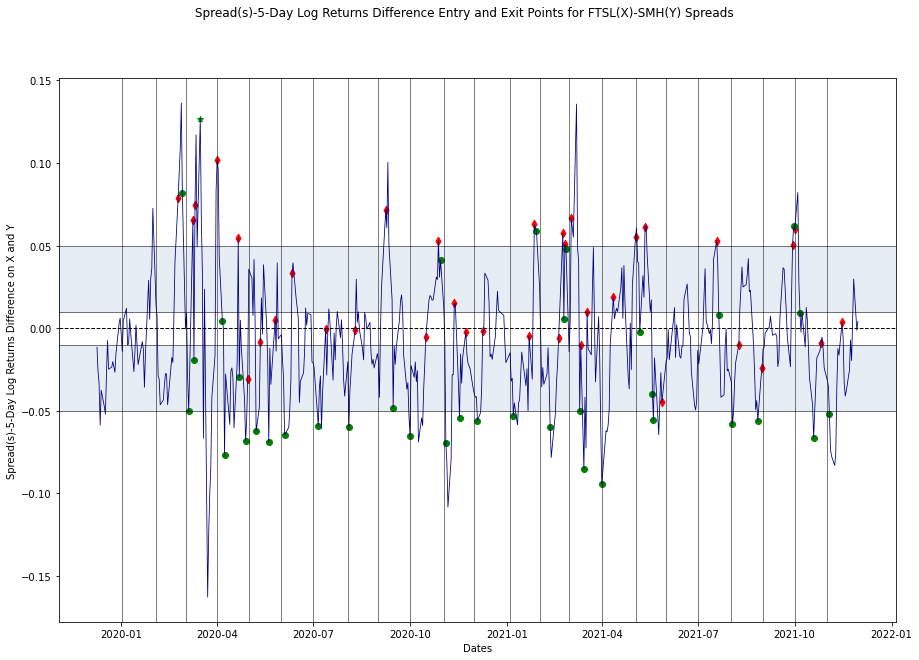

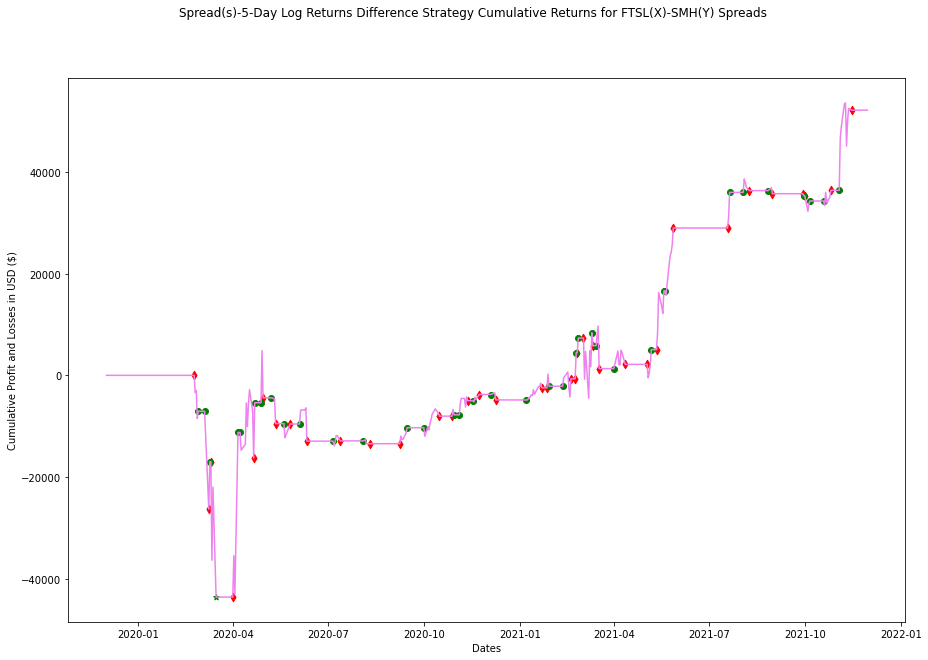

In [12]:
data_spread = spread_trade_strategy(data,5,0.05,0.01,0.9)
graph_spreads(data_spread, 5,0.05,0.01)

# 3. Analysis of trading strategy performance by varying its input parameters:

## 3.1 We will use 4 different example on different M, g, j, s for trading strategies 

**1.M=60(One quarter), g = 10%, j = 5%, s = 95%**

Cumulative Profits and Losses for the strategy is $49586.832, or 0.001%


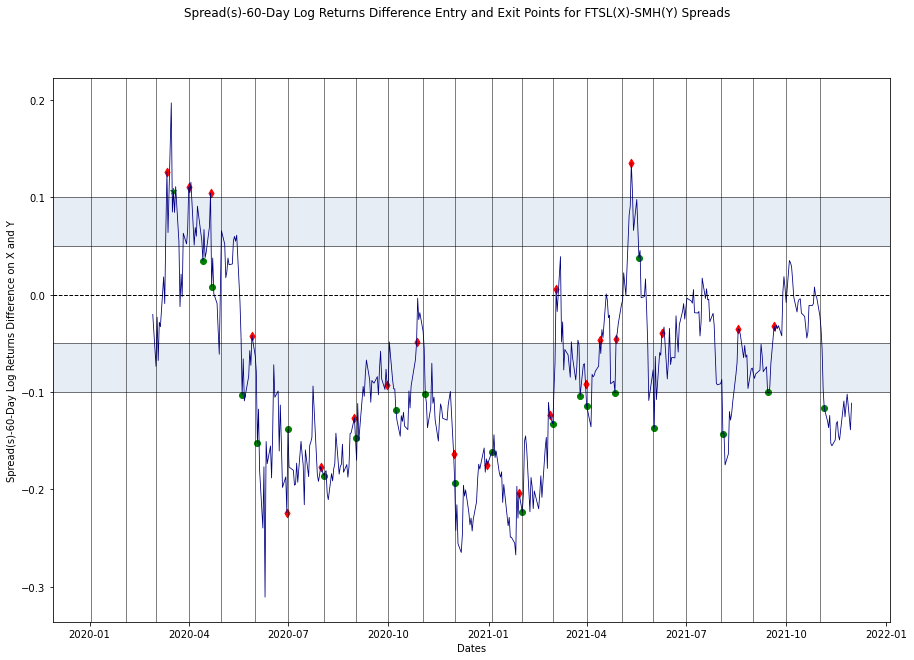

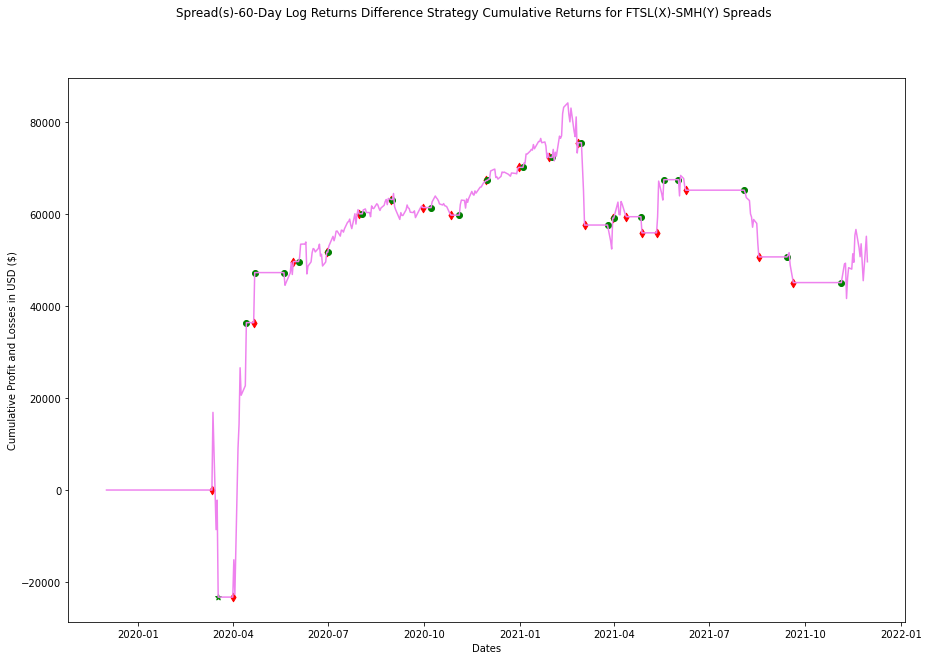

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05)
PL_DLY,98.387000,0.000000,31734.962000,0.000000,-25475.499000,2923.262000,1.207000,47.444000,-2656.294000,-4709.952000
Spread,-0.083000,-0.085000,0.197000,-0.022000,-0.311000,0.087000,0.186000,-0.379000,-0.219000,-0.226000


In [13]:
data_spread_example1 = spread_trade_strategy(data,60,0.10,0.05,0.95)
graph_spreads(data_spread_example1, 60,0.10,0.05)
table_statistics(data_spread_example1[['PL_DLY','Spread']],0.05).T

**2.M=20(One month), g = 8%, j = 3%, s = 90%**

Cumulative Profits and Losses for the strategy is $33754.772, or 0.001%


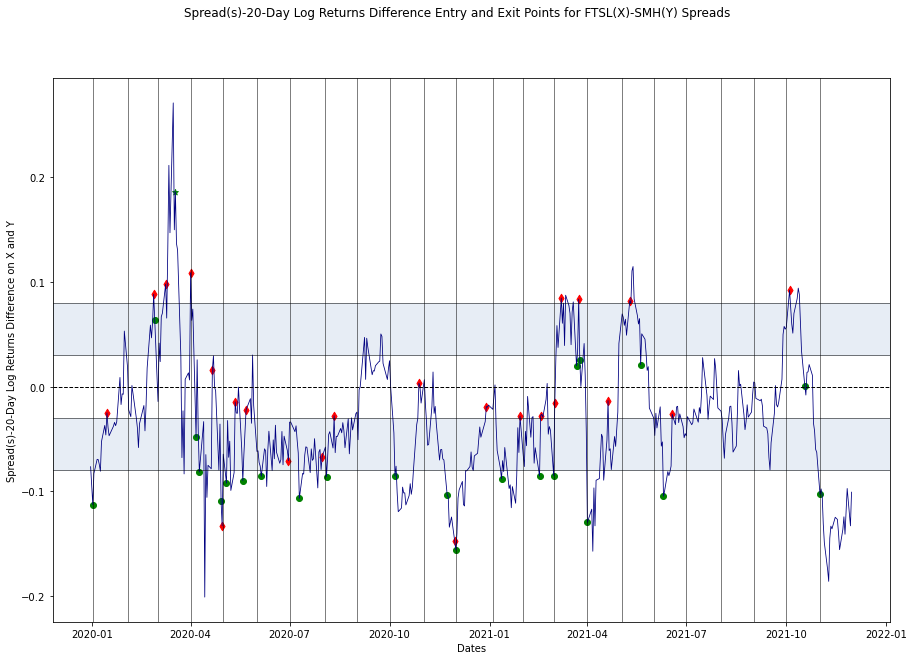

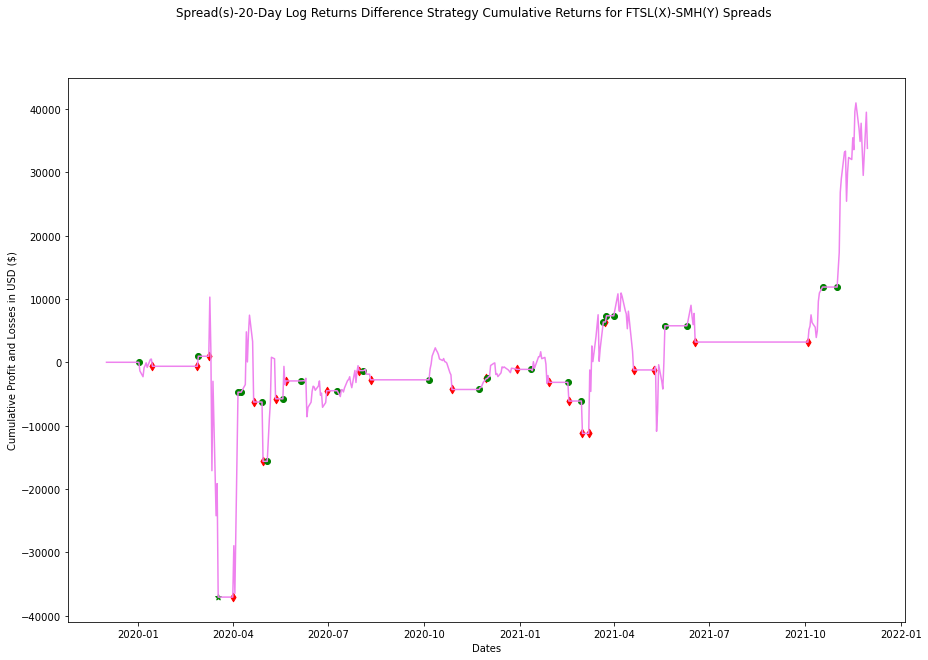

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05)
PL_DLY,66.974000,0.000000,31734.962000,0.000000,-21213.746000,2968.486000,0.961000,38.445000,-2667.344000,-4815.750000
Spread,-0.030000,-0.036000,0.271000,0.002000,-0.201000,0.062000,0.699000,1.551000,-0.124000,-0.132000


In [14]:
data_spread_example2 = spread_trade_strategy(data,20,0.08,0.03,0.9)
graph_spreads(data_spread_example2, 20,0.08,0.03)
table_statistics(data_spread_example2[['PL_DLY','Spread']],0.05).T

**3.M=10(Two weeks), g = 10%, j = 3%, s = 85%**

Cumulative Profits and Losses for the strategy is $-39065.481, or -0.001%


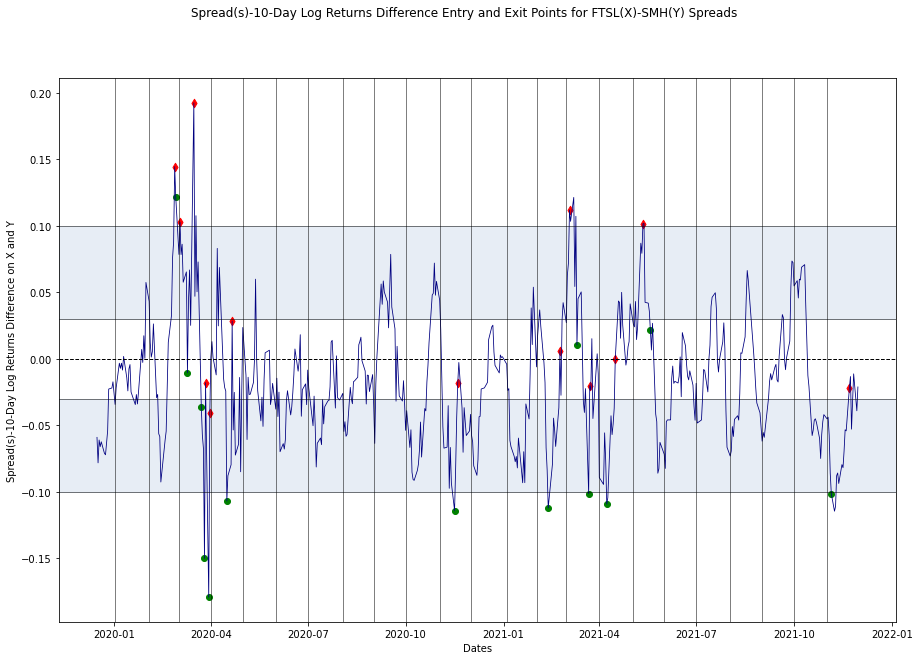

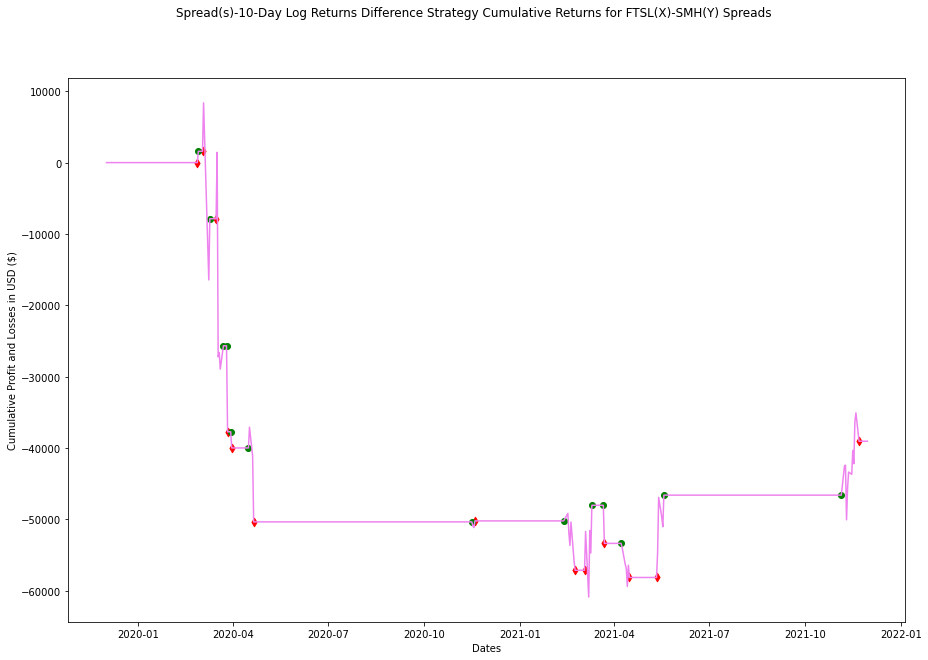

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05)
PL_DLY,-77.511000,0.000000,9333.327000,0.000000,-28671.020000,2094.099000,-5.819000,79.657000,-572.676000,-3521.998000
Spread,-0.016000,-0.019000,0.192000,0.012000,-0.179000,0.049000,0.480000,0.691000,-0.086000,-0.096000


In [15]:
data_spread_example3 = spread_trade_strategy(data,10,0.10,0.03,0.85)
graph_spreads(data_spread_example3, 10,0.10,0.03)
table_statistics(data_spread_example3[['PL_DLY','Spread']],0.05).T

**4.M=5(One week), g = 5%, j = 1%, s = 80%**

Cumulative Profits and Losses for the strategy is $99178.678, or 0.002%


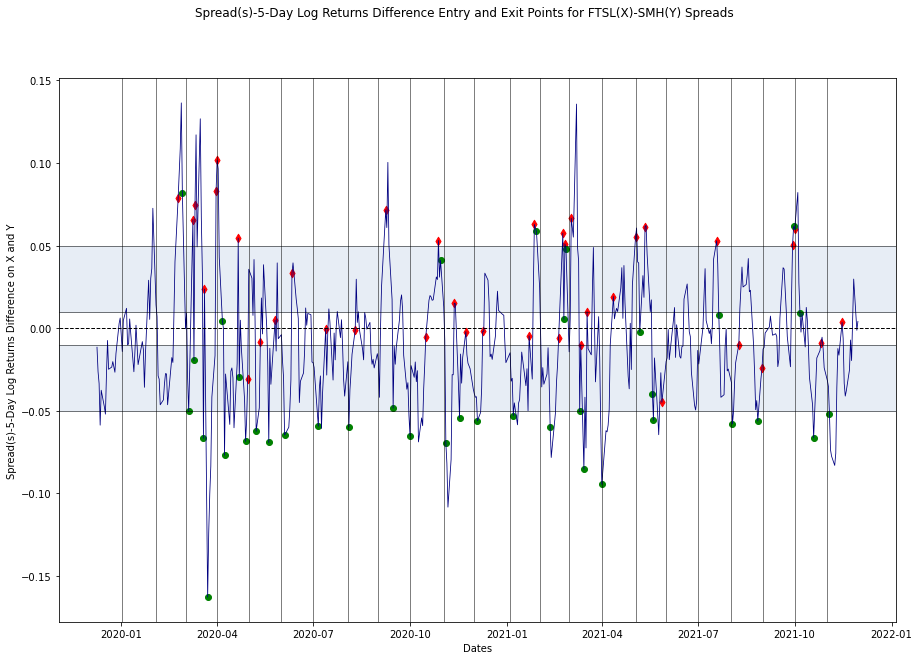

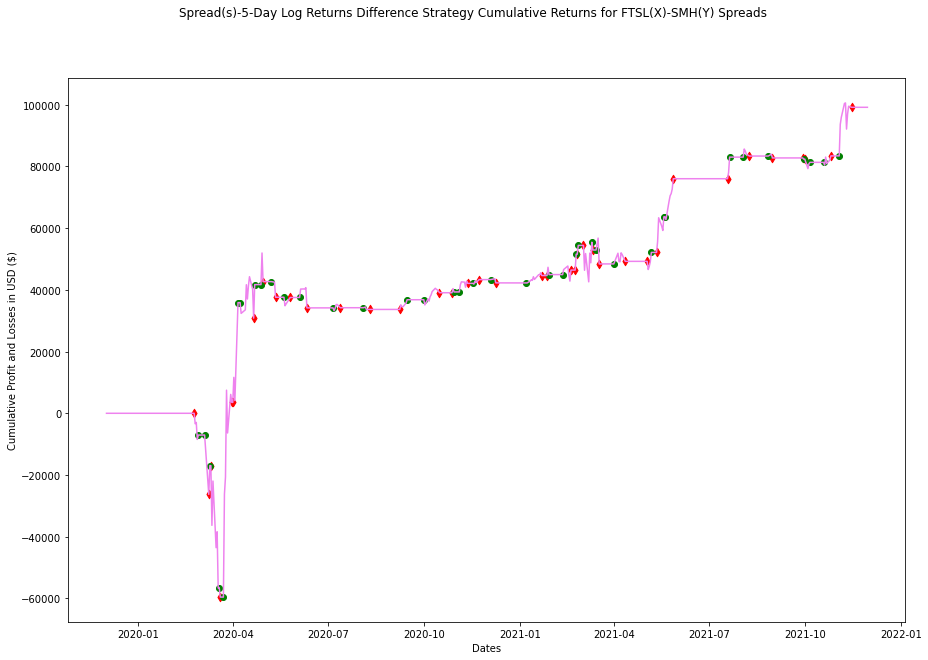

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05)
PL_DLY,196.783000,0.000000,33378.629000,0.000000,-21598.597000,3688.565000,2.631000,35.727000,-2744.216000,-5870.367000
Spread,-0.008000,-0.012000,0.136000,0.012000,-0.163000,0.039000,0.446000,1.401000,-0.064000,-0.072000


In [16]:
data_spread_example4 = spread_trade_strategy(data,5,0.05,0.01,0.8)
graph_spreads(data_spread_example4, 5,0.05,0.01)
table_statistics(data_spread_example4[['PL_DLY','Spread']],0.05).T

## 3.2 We will look at 'slices' for trading strategies 

**Let's do some analysis on the strategy. In particular, we look at how varying the parameters affects the absolute profitability of the strategy. Since there are 4 parameter inputs, we decided to look at 'slices' of the strategy: varying M, varying the width (or difference) of g and j, varying the level (or placement) of g and j, and varying s.**

**We can see above that the most profitable range of M for g = 0.05, j = 0.01 and s = 0.9 is 57. This strategy appears to work better as M increases. This makes sense, because there is more rolling data and a more 'stable' reversion. There seems to be a trade-off though between stability and more opportunities to exploit reversion. We can now see what happens when the gap of g and j is widened.**

**The following plot suggests that the profitability of the strategy increases as M increases:(g=10%,j=1%,s=90%)**

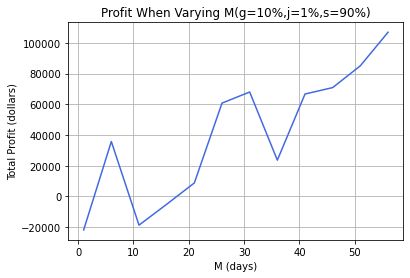

In [17]:
Perform_M = pd.DataFrame(columns = ['M','Cumulative_Profit'])
g = 0.10
j = 0.01
s = 0.9
for M in range(1,61,5):
  pl =simulateprofitandloss(data, M, g, j, s)
  Perform_M = Perform_M.append(pd.DataFrame([[M,pl]],columns=['M','Cumulative_Profit']),ignore_index=True)
plt.figure(3)
plt.plot(Perform_M.M,Perform_M.Cumulative_Profit,color='royalblue') # M=12 looks optimal
plt.title('Profit When Varying M(g=10%,j=1%,s=90%)')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('M (days)')
plt.grid()

**The following plot suggests that the profitability of the strategy increases as g-j increases:(M=60,g=10%,s=90%)**

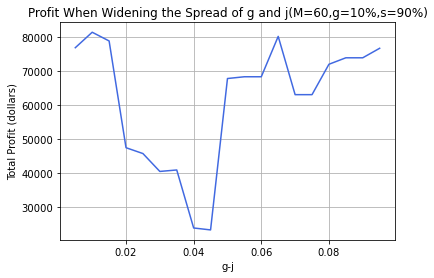

In [18]:
# check overall profit when widening the spread of g and j
Perform_W = pd.DataFrame(columns = ['W','Cumulative_Profit'])
M = 60
s = 0.9
g = 0.1
for i in range(1,20):
  j  = g- 0.005*i
  pl = simulateprofitandloss(data, M, g, j, s)
  Perform_W = Perform_W.append(pd.DataFrame([[g,j,g-j,pl]],columns=['G','J','W','Cumulative_Profit']),      ignore_index=True)
plt.figure(4)
plt.plot(Perform_W.W,Perform_W.Cumulative_Profit,color='royalblue') # window of 0.0011 looks good
plt.title('Profit When Widening the Spread of g and j(M=60,g=10%,s=90%)')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('g-j')
plt.grid()

**One interesting observation below is that when we bring g and j very close to zero, the returns appear to increase significantly.**

**This plot makes sense, in order to catch the reversion, the window of g and j must be in a particular spot.**

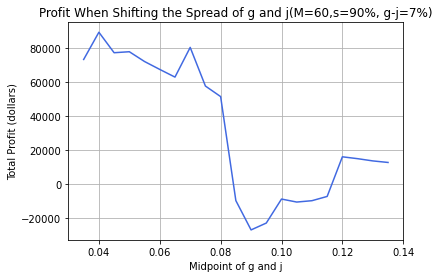

In [19]:
# check overall profit when shifting the spread of g and j
Perform_S = pd.DataFrame(columns = ['g','j','Cumulative_Profit'])

M = 60
s = 0.9

for i in range(0,21):
  i = i/200
  g = 0.07+i
  j = 0.00+i
  pl = simulateprofitandloss(data, M, g, j, s)
  Perform_S = Perform_S.append(pd.DataFrame([[g,j,pl]], columns=['g','j','Cumulative_Profit']),ignore_index=True)

plt.figure(5)
plt.plot((Perform_S.g+Perform_S.j)/2,Perform_S.Cumulative_Profit,color='royalblue') # window of 0.01 looks good
plt.title('Profit When Shifting the Spread of g and j(M=60,s=90%, g-j=7%)')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('Midpoint of g and j')
plt.grid()

**Finally we look at an optimal value for the stop loss:<br>
This plot shows that s for the stop loss in the beginning profitability stayed stable, until it decrease. A high stop loss seems to 'catch' the trade to much and exit too often. Even though higher stop loss levels seem to be more profitable in the analysis in general, realistically they should also be set based on the investor's risk appetite.<br>
I think that once trading costs are introduced, the spread would widen more to minimize trade frequency (higher trade frequencies would be penalized). For the same reason, I predict the stop loss threshold would decrease. Also, testing this reversion strategy for different ETFs may prove to be more profitable as well.**

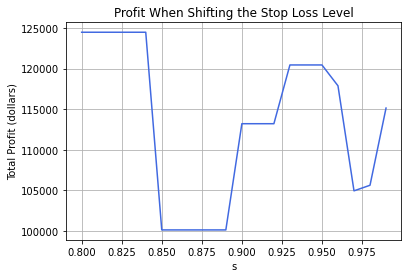

In [20]:
# check overall profit when varying the stop loss level
Perform_SL = pd.DataFrame(columns = ['s','Cumulative_Profit'])
M = 60
g = 0.03
j = 0.01
for s in range(99,79,-1):
  s = s/100
  pl = simulateprofitandloss(data, M, g, j, s)
  Perform_SL = Perform_SL.append(pd.DataFrame([[s,pl]],columns=['s','Cumulative_Profit']),ignore_index=True)
plt.figure(6)
plt.plot(Perform_SL.s,Perform_SL.Cumulative_Profit,color='royalblue') # window of 0.0004 looks good
plt.title('Profit When Shifting the Stop Loss Level')
plt.ylabel('Total Profit (dollars)')
plt.xlabel('s')
plt.grid()

## 3.3 We will look at optimal for trading strategies 

**The simulation takes so much time(more than 40 minutes) to run that we need to put it at the end of the analysis.**

**We found that $M = 60, g = 2\% \, , j = 1\% \, , s = 0.80 \, $ provide the optimal PnL results.**

**M=60(near One quarter), g = 2%, j = 1%, s = 80%**

Cumulative Profits and Losses for the strategy is $153877.441, or 0.002%


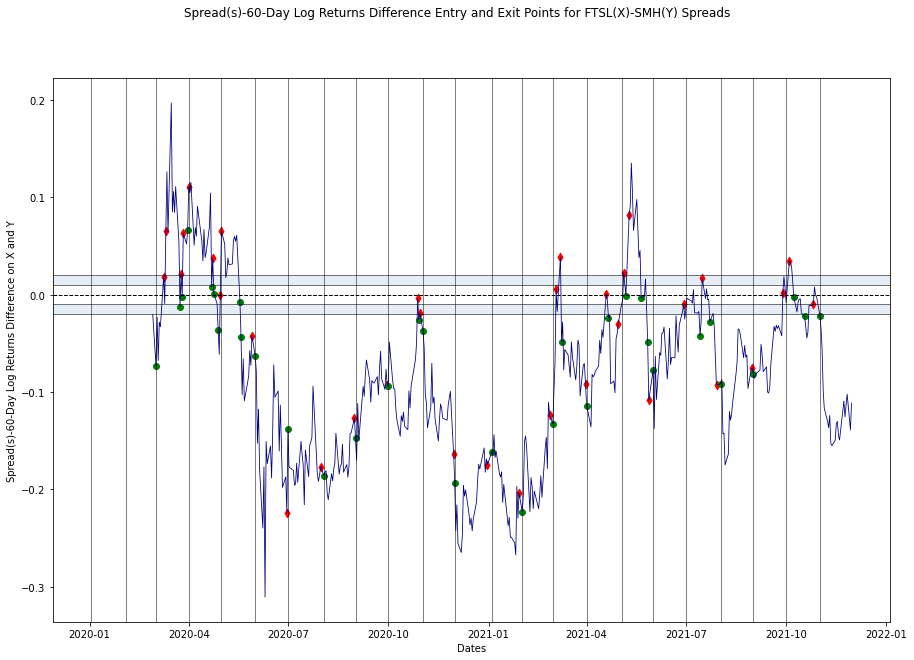

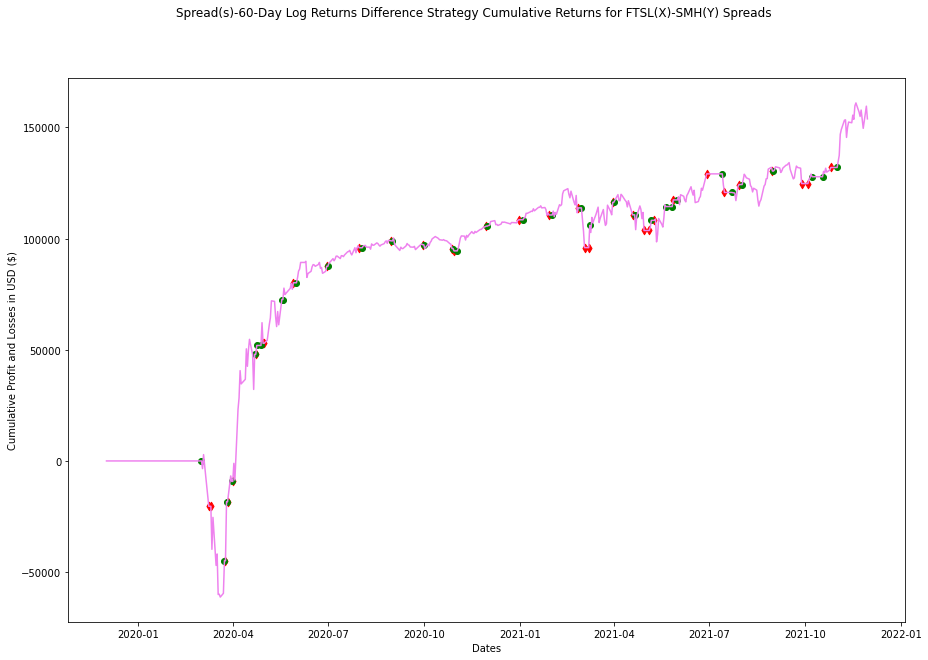

,Mean,Median,Max,75% Quantile,Min,Std.Dev,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05)
PL_DLY,305.312000,0.000000,31734.962000,1212.806000,-21598.597000,3989.243000,1.003000,16.263000,-5097.274000,-6256.408000
Spread,-0.083000,-0.085000,0.197000,-0.022000,-0.311000,0.087000,0.186000,-0.379000,-0.219000,-0.226000


In [21]:
data_spread_optimal = spread_trade_strategy(data,60,0.02,0.01,0.80)
graph_spreads(data_spread_optimal, 60,0.02,0.01)
table_statistics(data_spread_optimal[['PL_DLY','Spread']],0.05).T

In [22]:
data_spread_optimal

,FTSL:Adj_Volume,FTSL:Adj_Close,FTSL:Dollar_Volume_m,SMH:Adj_Volume,SMH:Adj_Close,SMH:Dollar_Volume_m,Dollar_Volume_Min_m,Nt,Capital K,StartMonth,EndMonth,FTSL:MDret,SMH:MDret,Spread,Signal,Position,X_Shares,Y_Shares,X_MV,Y_MV,GTCash,StopLossLevel,OpenGrossMV,StopLossSignal,PL_DLY,PL_LTD,NAV,Mark,StopLossDay,Returns_DLY,Returns_LTD,StopLossMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-02,107610.000000,44.037044,4.738826,4547649.000000,127.661864,580.561347,4.738826,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-03,135498.000000,44.064897,5.970705,6834523.000000,125.871211,860.269687,5.970705,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-04,185723.000000,44.139175,8.197660,3237730.000000,127.720255,413.523700,8.197660,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-05,169047.000000,44.269160,7.483569,2438125.000000,128.489068,313.272408,7.483569,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-06,224025.000000,44.232021,9.909078,3375766.000000,130.396502,440.188078,9.909078,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-09,248316.000000,44.167307,10.967449,1975447.000000,129.520639,255.861158,10.967449,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-10,148984.000000,44.343437,6.606463,2538622.000000,130.036425,330.113330,6.606463,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-11,148313.000000,44.389860,6.583593,4807275.000000,132.819722,638.500931,6.583593,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No
2019-12-12,196509.000000,44.393295,8.723682,6028566.000000,136.634591,823.710651,8.723682,NaN,61372925.807253,0,0,NaN,NaN,NaN,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,No,0.000000,0.000000,61372925.807253,No,No,0.000000,0.000000,No


# 4. Analysis of Optimal Trading Strategy via ratios calculations and regressions:

## 4.1  Stationarity check for optimal trading strategies M=60, g = 2%, j = 1%, s = 80%

**We will check optimal trading strategies for seasonality, and seeing if the residuals are stationary.**

**By conducting the seasonality check, the 60 day returns and the residuals are stationary. This conlusion supports the fact that a spread trade is viable over extended periods of time.**

In [23]:
print("FTSL(X)-SMH(Y) Spreads: {}\nP-value: {:.2f}\nStationary: {}".format('M=60 Day Returns,g=2%,j=1%,s=80%',adfuller(data_spread_optimal.loc[:,'Spread'].dropna())[1],"From the Stationarity check it is STATIONARY" if adfuller(data_spread_optimal.loc[:,'Spread'].dropna())[1] < 0.05 else "From the Stationarity check it is NOT stationary"))

FTSL(X)-SMH(Y) Spreads: M=60 Day Returns,g=2%,j=1%,s=80%
P-value: 0.04
Stationary: From the Stationarity check it is STATIONARY


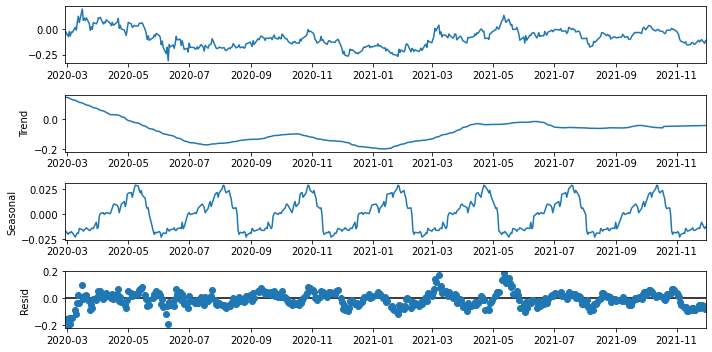

The residuals of FTSL(X)-SMH(Y) Spreads are STATIONARY.
P-value=0.00


In [24]:
data_spread_optimal_decompose= seasonal_decompose(data_spread_optimal.loc[:,['Spread']].dropna(), model = 'additive',extrapolate_trend = 'freq', period = 60)
plt.rcParams['figure.figsize'] = [10,5]
data_spread_optimal_decompose.plot()
plt.show()
print("The residuals of FTSL(X)-SMH(Y) Spreads are STATIONARY.\nP-value={:.2f}".format(adfuller(data_spread_optimal_decompose.resid.dropna())[1]) if adfuller(data_spread_optimal_decompose.resid.dropna())[1] < 0.05 else "The residuals of FTSL(X)-SMH(Y) Spreads are NOT stationary.")

## 4.2 Return analysis for optimal trading strategies M=60, g = 2%, j = 1%, s = 80%

**The return in percentages of the optimal trading strategy is only 0.249%, which is 153,877 over Capital K 61,372,926.**

In [25]:
print("FTSL(X)-SMH(Y) Spreads(M=60,g=2%,j=1%,s=80%) return is {}".format(data_spread_optimal['Returns_LTD'][-1]))

FTSL(X)-SMH(Y) Spreads(M=60,g=2%,j=1%,s=80%) return is 0.0024978599685744223


## 4.3 Maximum Drawdown(Loss) analysis for optimal trading strategies M=60, g = 2%, j = 1%, s = 80%

**We can observe that our optimal trading stratedy has positive skew ,and because we implement the strategy to gain large rewards when the M day return spread mean revert, and stop losses at 80% of gross traded cash to constrain extreme losses in opposite scenarios.**

**We can observe that the largest drawdown period of our optimal trading strategies started from March 2,2021 to March 20, 2021. During this time period, because of the impact of lockdown effect on financial market. The asset class became extremely correlated. <br>**

**Our optimal trading strategies had already started the month by signaling BuyXSellY on the spread, which resulted in loss around 20,397.<br>
And then our optimal trading strategies signalled SellXBuyY on March 12,2021 to March 20, which resulted in cumulative maximum loss around 61,244.<br>
We can observe that Stop Loss was not triggered through the selloff of both ETFs(FTSL(First Trust Senior Loan ETF)-SMH(VanEck Semiconductor ETF))**

In [26]:
table_maxdrawdown(data_spread_optimal[['PL_DLY','Returns_DLY']],0.05,False).T

,Skewness,Excess Kurtosis,VaR (Q0.05),VaR (N0.05),Expected Shortfall,Max Drawdown,Max Drawdown Start,Max Drawdown End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
PL_DLY,1.003232,16.263416,-5097.273806,-6256.407850,-9161.253861,-64086.669302,2020-03-04,2020-03-20,2020-04-06,-21598.597139,2020-03-16,33
Returns_DLY,1.001173,16.300707,-0.000083,-0.000102,-0.000149,-0.001045,2020-03-04,2020-03-20,2020-04-06,-0.000352,2020-03-16,33


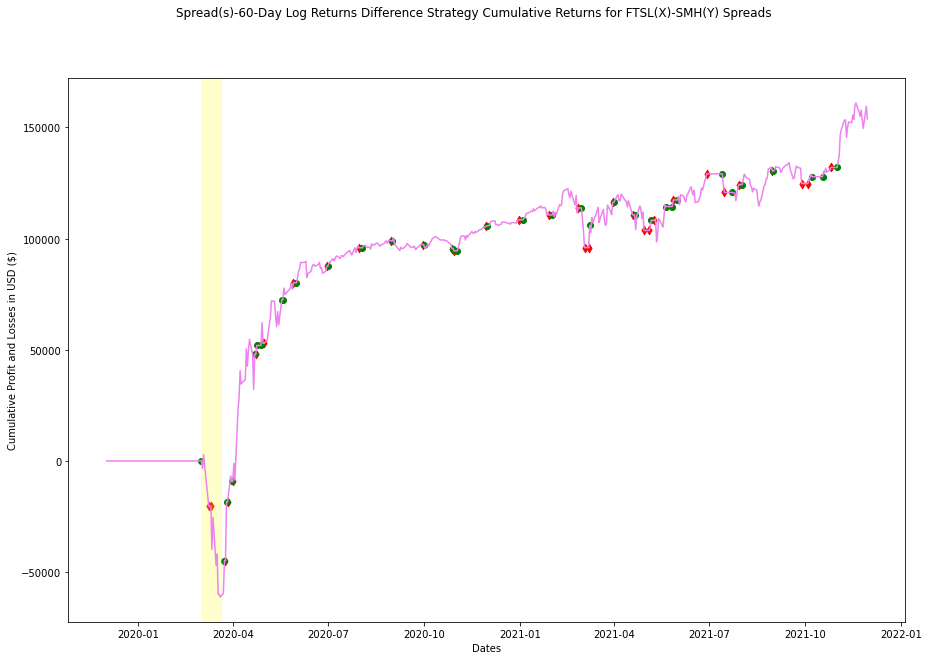

In [27]:
fig, ax1 = plt.subplots(figsize = (15,10))
fig.suptitle('Spread(s)-{}-Day Log Returns Difference Strategy Cumulative Returns for FTSL(X)-SMH(Y) Spreads'.format(M))
ax1.plot(data_spread_optimal[['PL_LTD']],'violet')
plt.scatter(data_spread_optimal[(data_spread_optimal['Mark'] == 'SellXBuyY')]['Spread'].index, data_spread_optimal[(data_spread_optimal['Mark'] == 'SellXBuyY')]['PL_LTD'], color='red', marker='d', alpha=1)
plt.scatter(data_spread_optimal[(data_spread_optimal['StopLossMark'] == 'SellXBuyYF')]['Spread'].index, data_spread_optimal[(data_spread_optimal['StopLossMark'] == 'SellXBuyYF')]['PL_LTD'], color='red', marker='H', alpha=1)
plt.scatter(data_spread_optimal[(data_spread_optimal['Mark'] == "BuyXSellY")]['Spread'].index, data_spread_optimal[(data_spread_optimal['Mark'] == "BuyXSellY")]['PL_LTD'], color='green', marker='o', alpha=1)
plt.scatter(data_spread_optimal[(data_spread_optimal['StopLossMark'] == 'BuyXSellYF')]['Spread'].index, data_spread_optimal[(data_spread_optimal['StopLossMark'] == 'BuyXSellYF')]['PL_LTD'], color='green', marker='*', alpha=1)
plt.axvspan(['2020-03-02'], ['2020-03-21'], color='yellow', alpha=0.2)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Cumulative Profit and Losses in USD ($)')
plt.show()

## 4.4 Fama French analysis for optimal trading strategies M=60, g = 2%, j = 1%, s = 80%

**When we looked at correlation, we found that the relationship of relation between our optimal trading strategies return  correlate with Market minus Risk free rate. Given this observations, we think our optimal trading strategy correlated to the market, which can be observed from the Maximum Drawdown period during March 2020.**

In [28]:
data_spread_optimal_return = data_spread_optimal.loc[:,['Returns_DLY']] * 100
pd.options.display.float_format = '{:,.6f}'.format
data_spread_ff5_comparison = pd.concat([data_spread_optimal_return,ff5],axis=1)
data_spread_ff5_comparison.corr()

,Returns_DLY,Mkt-RF,SMB,HML,RF
Returns_DLY,1.000000,0.723857,0.133571,0.037506,-0.045749
Mkt-RF,0.723857,1.000000,0.137746,0.193231,-0.075146
SMB,0.133571,0.137746,1.000000,0.209657,-0.052786
HML,0.037506,0.193231,0.209657,1.000000,-0.080175
RF,-0.045749,-0.075146,-0.052786,-0.080175,1.000000


**The R-Squared is 53.8% when we are regressing the strategy returns against the Fama French factors. This suggested that there is some beta relationship.**

In [29]:
OLSreport(data_spread_optimal_return,ff5)

                            OLS Regression Results                            
Dep. Variable:            Returns_DLY   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     145.2
Date:                Thu, 27 Jan 2022   Prob (F-statistic):           3.09e-82
Time:                        22:22:13   Log-Likelihood:                 2018.3
No. Observations:                 504   AIC:                            -4027.
Df Residuals:                     499   BIC:                            -4006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.828      0.4

(('Beta:',
  Mkt-RF    0.002919
  SMB       0.000429
  HML      -0.000547
  RF        0.009460
  dtype: float64),
 'Alpha (Ann): 0.04525 R-Squared: 0.53787 Tracking Error: 0.07010')

# 5. Conclusion

**Our above analysis shows that for a mean-reversion spread(M-day) strategy on the ETF pair FTSL(First Trust Senior Loan ETF)-SMH(VanEck Semiconductor ETF). After we run the 972 simulations,  we found that $g = 10\% \, , j = 1\% \, , s = 0.80 \, , M = 60$ provide the most optimal PnL results.<br>**

**For optimizing the PnL results,<br>
First of all, I would recommend to increase gross traded cash. Currently the average $N_t$ is only 14.4Million USD compared to capital K which is 61.9Million USD.<br>
Secondly, we can use longer timeframe to do further analysis on how performance can be enhanced.**

## 6. Trying out different values to find Optimum Parameters

**The simulation takes so much time to run that we need to put it at the end of the analysis.**

**We will lay out various scenarios of M, g, j, and s. This will be achieved by iterating through the different scenarios.<br>
For M, we will using business days,which will be the daily, weekly, monthly, and quarterly periods.<br>
For s, we will try setting with increments of 10%, starting from 70% to 100%.**

**After running 972 simulations based on the constraints described above, the below results are obtained. (We highlight in particular the top 30 and bottom 30 scenarios in terms of PnL.)**

In [30]:
Perform_simulation=[]
for mm in [5,10,20,60]: #M
    for gg in np.arange(0.01,0.10,0.01): #g
        for jj in np.arange(0.00,0.09,0.01): #j
            for ss in np.arange(0.70,1.00,0.10): #s
                Perform_simulation.append([mm,gg,jj,ss,simulateprofitandloss(data, mm,gg,jj,ss)])

results1=pd.DataFrame(Perform_simulation,columns=["M","g","j","s","Pnl"])                
results1['j']=np.round(results1['j'],3)
results1['g']=np.round(results1['g'],3)
results1['s']=np.round(results1['s'],4)

In [31]:
print("Top 30 PNL for (FTSL(X)-SMH(Y) Spreads) generating combinations are:")
print(results1.sort_values("Pnl",ascending=False).head(30))
print("Last 30 PNL for (FTSL(X)-SMH(Y) Spreads) generating combinations are:")
print(results1.sort_values("Pnl",ascending=False).tail(30))

Top 30 PNL for (FTSL(X)-SMH(Y) Spreads) generating combinations are:
       M        g        j        s            Pnl
0      5 0.010000 0.000000 0.700000 174,013.879129
973   60 0.010000 0.000000 0.800000 167,093.717156
972   60 0.010000 0.000000 0.700000 167,093.717156
981   60 0.010000 0.020000 0.800000 163,476.546447
980   60 0.010000 0.020000 0.700000 163,476.546447
976   60 0.010000 0.010000 0.700000 162,290.384324
977   60 0.010000 0.010000 0.800000 162,290.384324
12     5 0.010000 0.030000 0.700000 161,767.707895
13     5 0.010000 0.030000 0.800000 161,767.707895
1      5 0.010000 0.000000 0.800000 161,754.503715
36     5 0.020000 0.000000 0.700000 158,126.689045
1009  60 0.020000 0.000000 0.800000 156,426.901987
1008  60 0.020000 0.000000 0.700000 156,426.901987
984   60 0.010000 0.030000 0.700000 154,345.882743
985   60 0.010000 0.030000 0.800000 154,345.882743
72     5 0.030000 0.000000 0.700000 154,196.200592
73     5 0.030000 0.000000 0.800000 154,076.910920
48     5 0.02